# Workshops

## Warm-up

In [1]:
def payoff(s, k):
    # your code
    return 

In [2]:
S = 90      # price at delivery
K = 95      # delivery price

print('Profit/loss is: ', payoff(S, K))

Profit/loss is:  None


## Building the framework for AAD

### Polymorphism in Python

Overwriting built-in methods for various types of variables


In [3]:
class Date:
    def __init__(self, week, day):
        self.week = week
        self.day = day
        
    def __repr__(self):
        return f"Week no. {self.week}, day no. {self.day} "
    
    def __add__(self, other):
        days = self.day + other.day
        weeks = self.week + other.week
        if (days > 7):
            days -= 7
            weeks += 1
        return Date(weeks, days)
            
date1 = Date(10, 5)
date2 = Date(2, 3)

date3 = date1 + date2
print(date3)

Week no. 13, day no. 1 


### Creating classes

In [2]:
from collections import defaultdict
from math import sqrt
import numpy as np

In [3]:
class Derivative:
    """ Enabling the usage of +, *, -, etc. """
    def __add__(self, other):
        return Add(self, other)
    
    def __sub__(self, other):
        return Sub(self, other)
    
    def __mul__(self, other):
        return Mul(self, other)
    
    def __truediv__(self, other):
        return Div(self, other)
   
    def Sin(self):
        return Sin(self)
    
    def __pow__(self, power):
        return Pow(self, power)
    
    
    def __hash__(self):                 # we need this for creating the dictionary with keys as Derivatives object
        return hash(str(self))

Leaf nodes

In [4]:
class Var(Derivative):
    """ A leaf node (a node which doesn't have any child) """
    
    def __init__(self, value):
        self.value = value      # the scalar value of the node

Adding the nodes

In [5]:
class Add(Derivative):
    """ The node that results from adding two nodes """
    
    def __init__(self, node_a, node_b):
        self.value = node_a.value + node_b.value    # vaue of the node
        self.grad = [(node_a, 1), (node_b, 1)]      # partial derivatives of nodes

Substract the nodes

In [6]:
class Sub(Derivative):
    """ The node that results from subtraction two nodes """
    
    def __init__(self, node_a, node_b):
        self.value = node_a.value - node_b.value   # value of the node
        self.grad = [(node_a, 1), (node_b, -1)]    # partial derivatives of nodes

Multiplication of nodes

In [7]:
class Mul(Derivative):
    """ The node that results from multiplying two nodes """
    
    def __init__(self, node_a, node_b):
        self.value = node_a.value * node_b.value
        self.grad = [(node_a, node_b.value), (node_b, node_a.value)]

Dividing nodes

In [8]:
class Div(Derivative):
    """ The node that results from dividing one nodes by another """
    
    def __init__(self, node_a, node_b):
        self.value = node_a.value / node_b.value
        self.grad = [(node_a, 1/node_b.value), (node_b, -node_a.value/node_b.value**2)] # f = x/y   df / dy = -x / (y^2)

Sinus of one node

In [9]:
class Sin(Derivative):
    """ The node that results from sin(node) """
    
    def __init__(self, node):
        self.value = np.sin(node.value) # use np.sin() function
        self.grad = [ ( node, np.cos(node.value) ) ] # only one derivative, 
                                                       #since it takes only one node - use np.cos() function

Powers

In [11]:
class Pow(Derivative):
    """ The node that results as node ^ power """
    
    def __init__(self, node, power):
        self.value = node.value**power              # reminder of power operation in python: **
        self.grad = [ ( node, power*(node.value**(power-1)) ) ] # (one derivative)    f = x^n   df/dx = n * x ^ (n-1)

### Create a function for getting the gradients values

The algorithm will return a dictionary 'gradients' which will have the nodes as keys and partial derivatives in respect to that nodes as values
so the structure will be e.g.:

gradients = {x1: 1, w1: 14}

We will go through the variable 'stack'. Stack will be a list of tuples (node, deriative).

Let's assume we have such a graph:

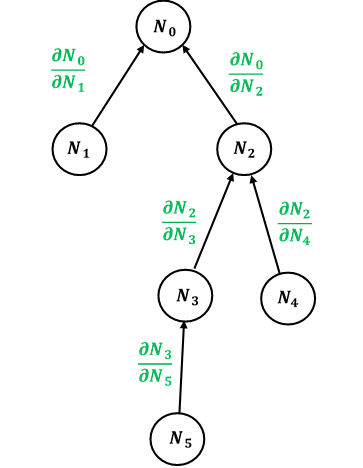

1. First, stack will be assigned with child nodes of the parent node

        stack = N0.grad

        stack = [ (N1,  dN0 / dN1),  (N2,  dN0 / dN2) ]
        

2. We will take the last element from the stack 

        stack = [ (N1,  dN0 / dN1) ]
        
        
    and save it in variables 'node' and 'node_derivative'

        node = N2

        node_derivative = dN0 / dN2
        
    
    then add the node_derivative to the gradients[node]

        gradients[node] = gradients[node] + node_derivative
        
        gradients[N2] = dN0 / dN2
        

3. If 'node' has children nodes, iterate through them AND append them onto a stack with their derivative multiplied by 'node_derivative'

    * child_node = N3,    child_node_derivative = dN2 / dN3

            stack = [ (N1,  dN0 / dN1), (N3, dN2 / dN3 * dN0 / dN2) ]
            
            
    * child_node = N4,    child_node_derivative = dN2 / dN4

            stack = [ (N1,  dN0 / dN1), (N3, dN2 / dN3 * dN0 / dN2), (N4, dN2 / dN4 * dN0 / dN2) ]
            
            
4. Take again last element from the stack and save in 'node' and 'node_derivative' and add 'node_derivative' to gradients[node]

        stack = [ (N1,  dN0 / dN1), (N3, dN2 / dN3 * dN0 / dN2) ]

        node = N4

        node_derivative = dN2 / dN4 * dN0 / dN2

        gradients[N4] = dN2 / dN4 * dN0 / dN2
            

5. N4 has no children, so do nothing

6. Take again last element from the stack - repeat step 4:

        stack = [ (N1, dN0 / dN1) ]

        node = N3

        node_derivative = dN2/dN3 * dN0/dN2 

        gradients[N3] = dN2/dN3 * dN0/dN2
            

7. Iterate through children of node N3 - repeat step 3:

        * child_node = N5,    child_node_derivative = dN3/dN5 * dN2/dN3 * dN0/dN2 

            stack = [ (N1, dN0 / dN1), ( N5, dN3/dN5 * dN2/dN3 * dN0/dN2 ) ]
            

8. What will be the next step?

        stack = [ (N1, dN0 / dN1) ]

        node = N5

        node_derivative = dN3/dN5 * dN2/dN3 * dN0/dN2

        gradients[N5] = dN3/dN5 * dN2/dN3 * dN0/dN2
        
        
9. Does N5 have children?

10. What is the next step?

        stack = [ ]

        node = N1

        node_derivative = dN0/dN1 

        gradients[N1] = dN0/dN1
        
        
11. What is the next step? When do we end?

In [21]:
def get_gradient(parent_node):
    """ Go down the graph, and compute derivative of `parent_node` with respect to each node """
    
    # we will create a dictionary 'gradient' which will have the nodes as keys and its derivatives as values
    # initialize the dictionary so when calling a non-existing key the value of 0 is assigned
    gradients = defaultdict(lambda: 0) 
    
    # stack will represent the list of tuples (node, node_derivative) 
    stack = parent_node.grad.copy()       
    
    while stack:  
    # loop for each different branch
        # get node and node_derivative from the top of the stack - function pop()
        node, node_derivative = stack.pop()
        
        # add to the value of derivative of the node (gradients[node] ) value node_derivative
        gradients[node] = gradients[node] + node_derivative
        
        # if the node has children, put them onto the stack
        if not isinstance(node, Var):        
            # loop for each node in one branch
            for child_node, child_node_derivative in node.grad: 
                # append child_node and child_node_derivative * node_derivative to the stack
                stack.append( (child_node,child_node_derivative * node_derivative) )
                                                    
    return dict(gradients)

In [1]:
bool([])

False

### Test the function

#### 1. Our example

$$ f(x_1, x_2, x_3) = \sin(x_2 + {x_1}^2) \frac{x_3 - x_1}{x_2} $$

$$ \frac{\partial f}{\partial x_1} = \sin(x_2 + {x_1}^2) (- \frac{1}{x_2}) + \frac{x_3-x_1}{x_2} \cos(x_2 + {x_1}^2) 2x_1 $$

In [22]:
# assign the values
x1_val = 2
x2_val = 1
x3_val = 3

In [23]:
def f(x1, x2, x3):
    if type(x1) == int: # check if type of arguments (any argument) is int - then return the equation with np.sin, otherwise Sin
        return np.sin(x2 + x1 ** 2) * (x3 - x1) / x2
    return Sin(x2 + x1 ** 2) * (x3 - x1) / x2

def part_f_x1(x1, x2, x3):
    return np.sin(x2 + x1 ** 2) * (-1 / x2) + ((x3 - x1)/x2 * np.cos(x2 + x1 ** 2)*2*x1)

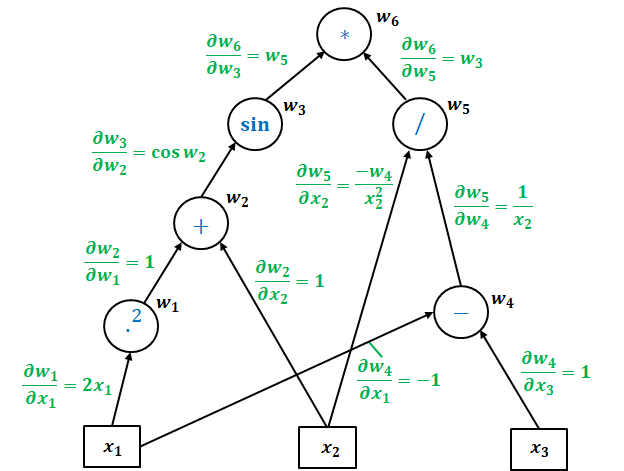

In [24]:
x1 = Var(x1_val)
x2 = Var(x2_val)
x3 = Var(x3_val)

y = f(x1, x2, x3)
gradients = get_gradient(y)

print('Value of f equals', y.value)
print('The partial derivative of y with respect to x1 =', gradients[x1])
print('grad x1:', gradients[x1], '\n',
     'grad x2:', gradients[x2], '\n',
     'grad x3:', gradients[x3])

Value of f equals -0.9589242746631385
The partial derivative of y with respect to x1 = 2.0935730165160433
grad x1: 2.0935730165160433 
 grad x2: 1.2425864601263648 
 grad x3: -0.9589242746631385


In [16]:
print('[Manual way] Value of f equals', f(x1_val, x2_val, x3_val))
print('[Manual way] Value of partial derivative of f with respect to x1 equals', part_f_x1(x1_val, x2_val, x3_val))

[Manual way] Value of f equals -0.9589242746631385
[Manual way] Value of partial derivative of f with respect to x1 equals 2.0935730165160433


#### 2. Other functions

In [1]:
def test(fun, der_fun, args):
    """ Testing function, arguments:
            fun - function with function equation
            der_fun - function which returns the gradient of the function
            args - list of x values
        Checks if the result of der_fun(args) is equal to get_gradients(fun(args))"""
    x_nodes = []
    for arg in args:
        x_nodes.append(Var(arg))
        
    final_node = fun(*x_nodes)
    test_gradients = get_gradient(final_node)    
    gradients = der_fun(*args)
    
    for i in range(len(args)):
        if round(test_gradients[x_nodes[i]], 3) != round(gradients[i], 3):
            print('Incorrect values for argument no.', i+1)
            return False
        
    print('The values of partial derivatives are: ', end=" ")
    for i in range(len(args)):
        print(f"df/dx{i+1}={round(test_gradients[x_nodes[i]], 2)}", end="   ")
        
    return True

In [ ]:
# Example of calling test - previous equation
def f0(x1, x2, x3):
    return Sin(x2 + x1 ** 2)*(x3 - x1) / x2


def der_f0(x1, x2, x3):
    p_x1 = np.sin(x2 + x1 ** 2) * (-1 / x2) + ((x3 - x1)/x2 * np.cos(x2 + x1 ** 2) * 2*x1)
    p_x2 = np.sin(x2 + x1 ** 2) * (x1 - x3) / (x2 ** 2) + np.cos(x2 + x1 ** 2) * (x3 - x1)/x2 
    p_x3 = np.sin(x2 + x1 ** 2) / x2
    return [p_x1, p_x2, p_x3]

# assign values
x1 = 2
x2 = 1
x3 = 3

# call test function
test(f0, der_f0, [x1, x2, x3])

$$ f_1(x_1, x_2) = (x_1 + x_2) x_1 $$

In [ ]:
def f1(x1, x2):
    return (x1 + x2) * x1

def der_f1(x1, x2):
    p_x1 = 2*x1 + x2
    p_x2 = x1
    return [p_x1, p_x2]

In [ ]:
# call test function
x1 = 10
x2 = 7
test(f1, der_f1, [x1, x2])

$$ f_2(x_1, x_2, x_3) = \frac{x_2^2 + x_3^3}{x_1} + x_2 * x_3 $$

In [ ]:
def f2(x1, x2, x3):
    return ((x2 ** 2 + x3 ** 3) / x1 + x2 * x3)

def der_f2(x1, x2, x3):
    p_x1 = -(x2 ** 2 + x3 ** 3) / (x1 ** 2)
    p_x2 = 2 * x2 / x1 + x3
    p_x3 = 3 * x3 ** 2 / x1 + x2
    return [p_x1, p_x2, p_x3]

In [ ]:
x1 = 19
x2 = 2
x3 = 10
test(f2, der_f2, [x1, x2, x3])

$$ f_3(x_1, x_2, x_3, x_4) = {(x_1 x_4 x_2)}^2 \frac{x_3}{1 - x_4} $$

In [ ]:
def f3(x1, x2, x3, x4):
    return (x1 * x4 * x2) ** 2 * x3 / (Var(1) - x4)

def der_f3(x1, x2, x3, x4):
    p_x1 = x3 / (1 - x4) * 2 * x1 * x4 * x2 * x4 * x2
    p_x2 = x3 / (1 - x4) * 2 * x1 * x4 * x2 * x1 * x4
    p_x3 = (x1 * x4 * x2) ** 2 / (1 - x4) 
    p_x4 = (x1 * x4 * x2) ** 2 * x3 / ((1 - x4) ** 2) + x3 / (1 - x4) * 2 * x1 * x4 * x2 * x1 * x2
    return [p_x1, p_x2, p_x3, p_x4]

In [2]:
x1 = 10
x2 = 3
x3 = 11
x4 = 0.6

test(f3, der_f3, [x1, x2, x3, x4])

NameError: name 'f3' is not defined